# 在自己的数据集上训练语义分割模型

同济子豪兄：https://space.bilibili.com/1900783

2022-10-21

## 进入 mmsegmentation 主目录

In [1]:
import os
os.chdir('mmsegmentation')

## 导入工具包

In [2]:
import os.path as osp
import numpy as np
from PIL import Image
from tqdm import tqdm

import mmcv
import matplotlib.pyplot as plt

%matplotlib inline

## 下载数据集

Standord Background 数据集主页：http://dags.stanford.edu/projects/scenedataset.html

该数据集包含 715 张由 [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) 和 [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/) 四个开源数据集中挑选出来的图片。

主要为室外场景，图像尺寸为320x240。

共 8 个类别：

- 天空 sky

- 树 tree

- 道路 road

- 草 grass

- 水 water

- 建筑物 building

- 山 mountain

- 前景物体

In [3]:
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz

--2022-10-21 22:46:00--  http://dags.stanford.edu/data/iccv09Data.tar.gz
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 14727974 (14M) [application/x-gzip]
正在保存至: “stanford_background.tar.gz”

ord_background.tar. 100%[===================>]  14.04M   260KB/s    用时 37s     

2022-10-21 22:46:37 (386 KB/s) - 已保存 “stanford_background.tar.gz” [14727974/14727974])



## 解压

In [3]:
# 删除旧的数据集文件夹（如有）
!rm -rf iccv09Data

In [4]:
!tar xf stanford_background.tar.gz

## 查看数据集中的图片

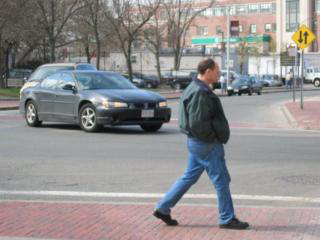

In [5]:
Image.open('iccv09Data/images/6000124.jpg')

## 数据集路径

In [6]:
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

## 语义分割类别和对应的颜色

In [7]:
# 类别和对应的颜色
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

## 转换语义分割标注格式为 segmentation map

In [8]:
for file in tqdm(mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt')):
    seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))

715it [00:24, 29.75it/s]


## 查看 segmentation map

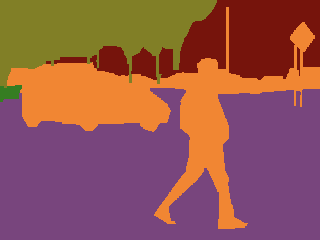

In [9]:
Image.open('iccv09Data/labels/6000124.png')

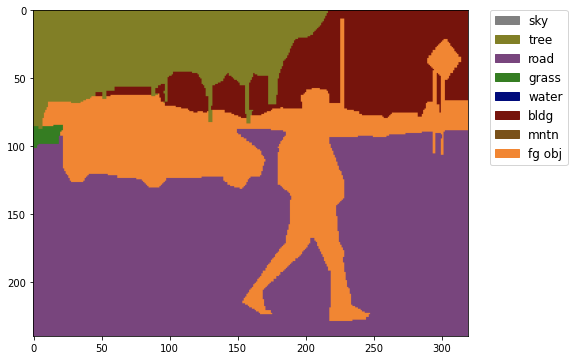

In [10]:
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

## 随机划分训练集和验证集

In [11]:
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # 随机选取 80% 数据作为训练集
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # 随机选取 20% 数据作为训练集
    f.writelines(line + '\n' for line in filename_list[train_length:])

在新数据集类 `StandfordBackgroundDataset` 中将类别名称和对应的颜色输入。

In [12]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

## 设置config文件

从预训练模型fine-tune微调训练模型

In [13]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

原始的config文件，是在cityscapes数据集上训练PSPNet的config文件。

我们需要根据自己的模型、数据集、训练超参数，修改config文件。

In [14]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# 模型结构
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# 数据集
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

# 数据预处理
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# 预训练权重
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoint/pspnet_r50-d8_512x1024_80k_cityscapes_20200606_112131-2376f12b.pth'

# 工作目录，存放模型结果和日志
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# 随机数种子
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

## 打印输出config文件

In [15]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=False,
  

## 准备训练

In [16]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建语义分割模型
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# 创建工作目录
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

2022-10-21 22:51:05,487 - mmseg - INFO - Loaded 572 images
/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


## 开始训练

In [17]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/environment/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-10-21 22:51:17,612 - mmseg - INFO - Loaded 143 images
2022-10-21 22:51:17,614 - mmseg - INFO - load checkpoint from local path: checkpoint/pspnet_r50-d8_512x1024_80k_cityscapes_20200606_112131-2376f12b.pth
2022-10-21 22:51:17,813 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 31.7 task/s, elapsed: 5s, ETA:     0s

2022-10-21 22:52:12,039 - mmseg - INFO - per class results:
2022-10-21 22:52:12,041 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 87.62 |  92.7 |
|  tree  | 68.72 | 80.11 |
|  road  | 87.08 | 93.99 |
| grass  | 75.27 | 89.19 |
| water  | 77.55 | 91.91 |
|  bldg  | 75.31 | 91.35 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 68.28 | 76.93 |
+--------+-------+-------+
2022-10-21 22:52:12,041 - mmseg - INFO - Summary:
2022-10-21 22:52:12,042 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.06 | 67.48 | 77.02 |
+-------+-------+-------+
2022-10-21 22:52:12,043 - mmseg - INFO - Iter(val) [143]	aAcc: 0.8706, mIoU: 0.6748, mAcc: 0.7702, IoU.sky: 0.8762, IoU.tree: 0.6872, IoU.road: 0.8708, IoU.grass: 0.7527, IoU.water: 0.7755, IoU.bldg: 0.7531, IoU.mntn: 0.0000, IoU.fg obj: 0.6828, Acc.sky: 0.9270, Acc.tree: 0.8011, Acc.road: 0.9399, Acc.grass: 0.8919, Acc.water: 0.9191, Acc.bldg: 0.913

## 使用训练得到的模型预测图像

In [18]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
model.cfg = cfg

In [19]:
img_path = 'iccv09Data/images/6000124.jpg'
result = inference_segmentor(model, img_path)

/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


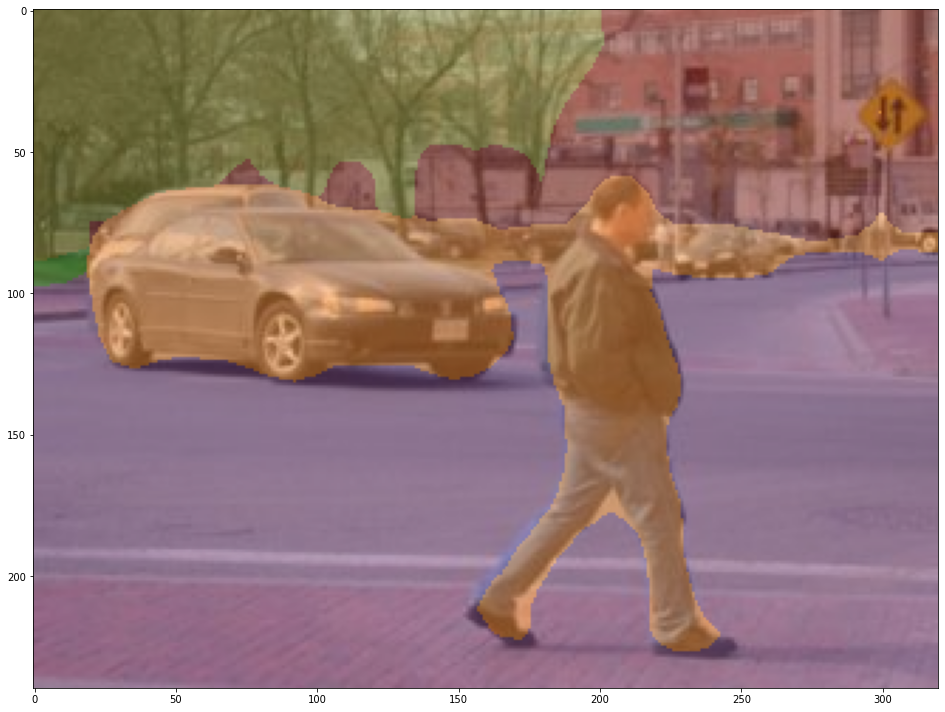

In [20]:
show_result_pyplot(model, img_path, result, palette, out_file='outputs/C.jpg')
plt.show()